# RNA-Seq Pearson's correlation


In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier

In [11]:
# The pathes (Directories) to the data
path2 = Path("/home/znazari/data/")
path3=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")

In [24]:
normalised_rna = pd.read_csv(path2/'mydata_TMM_Norm_Log2_CPM_filtered_batch_sex_effect_removed_RIN_covariate_06feb2024.txt',delimiter='\t', index_col=0)
transposed_norm = normalised_rna.T
transposed_norm.index = transposed_norm.index.str.lstrip('X')

In [25]:
# Read the file which contains diagnosis
diago=pd.read_csv(path3/"Participant_Status.csv", header=None )
diago1=diago.rename(columns=diago.iloc[0]).drop(diago.index[0]).reset_index(drop=True)

# Select only diagnosis with parkinson's and control.
selected_diagnosis_pd_hc = diago1[diago1['COHORT_DEFINITION'].isin(['Healthy Control', "Parkinson's Disease"])]

In [32]:
# Merge the DataFrames on the patient IDs
merged_df = pd.merge(transposed_norm, selected_diagnosis_pd_hc[['PATNO', 'COHORT_DEFINITION']], left_index=True, right_on='PATNO', how='left')

# Rename the new column as needed
merged_df = merged_df.rename(columns={'COHORT_DEFINITION': 'Diagnosis'})

# Display or use the merged DataFrame (merged_df)
merged_df.set_index("PATNO", inplace = True)

In [33]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'COHORT' column
label = label_encoder.fit_transform(merged_df['Diagnosis'])

# Set the label for parkinson's disease and healthy control
merged_df.loc[:, 'Diagnosis'] = label

In [34]:
df = merged_df

## Pearson's Correlation


In [35]:
# Extracting gene expression and diagnosis columns
gene_expression = df.drop('Diagnosis', axis=1)  # Drop 'Diagnosis' column from gene expression data
diagnosis = df['Diagnosis']

# Calculate Pearson correlation for each gene and store in a dictionary
correlation_dict = {}
for gene in gene_expression.columns:
    correlation_coefficient, _ = pearsonr(gene_expression[gene], diagnosis)
    correlation_dict[gene] = abs(correlation_coefficient)

# Sort the genes by the absolute correlation coefficient in descending order
sorted_genes = sorted(correlation_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 50% of genes
top_20_percent = int(0.1 * len(sorted_genes))
selected_genes = [gene[0] for gene in sorted_genes[:top_20_percent]]


## XGboost algorithm with hyperparametrs 

In [37]:
# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 300}
seed = 42

# Keep only the columns in the selected_genes list
selected_gene_expression = gene_expression[selected_genes]

# Separate features (X) and target variable (y)
X = selected_gene_expression
y = diagnosis

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate AU-ROC score
au_roc_score = roc_auc_score(y_test, y_pred_proba)
print(f'AU-ROC Score: {au_roc_score:.4f}')

# Optional: Cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=10, scoring='roc_auc')
print(f'Cross-validated AU-ROC Scores: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})')


AU-ROC Score: 0.7310
Cross-validated AU-ROC Scores: 0.6861 (±0.0950)


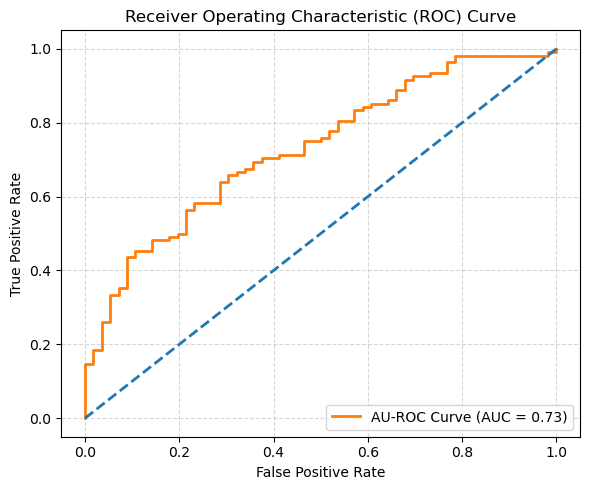

In [38]:
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Create a new figure
plt.figure(figsize=(6, 5))

# Plot the ROC curve
plt.plot(fpr, tpr, color='tab:orange', lw=2, label=f'AU-ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='tab:blue', lw=2, linestyle='--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


In [10]:
# Get the current date
current_date = datetime.now().date()

# Print the current date
print("Last update :", current_date)

Last update : 2024-02-28
